## IMPORTS

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from metrics.overallscore import calculate_overall_score
from metrics.dataquality import calculate_data_quality_metrics
from metrics.dataquality import calculate_phone_number_metrics
from metrics.dataquality import calculate_email_metrics
from metrics.dataquality import calculate_average_metrics
from metrics.overallscore import calculate_overall_score_mom
from metrics.datacollectorscore import calculate_quality_score_by_collector

## READING DATA

In [11]:
# data = pd.read_csv("data/ecg/customers_sep_nov.csv")
data = pd.read_csv("data/ecg/customers_two.csv")
data_v2 = pd.read_csv("data/ecg/customers_v2_.csv")

In [12]:
column_mapping = {
    'slrn': 'SLRN',
    'ac_no': 'Account Number',
    'meter_number': 'Meter Number',
    'meter_status': 'Meter Status',
    'meter_slrn': 'Meter SLRN',
    'phone_number': 'Phone Number',
    'email': 'Email',
    'date': 'Date',
    'first_captured_username': 'First Captured Username',
    'updated_username': 'Updated Username'
}
data_x = data_v2.copy()
data_x.rename(columns=column_mapping, inplace=True)

In [13]:
df = data_x

## METRICS

In [18]:
# List to store metrics for each key field
metrics_list = []

# Calculate metrics for each key field
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

for field_name in key_fields:
    if field_name in df.columns:
        if field_name in ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN']:
            metrics = calculate_data_quality_metrics(df, field_name, 'ECGBD', 12, 'ECGCR', 11)
        elif field_name == 'Phone Number':
            metrics = calculate_phone_number_metrics(df, field_name, 'ECGBD', corresponding_meter_field='Meter Number')
        elif field_name == 'Email':
            metrics = calculate_email_metrics(df, field_name, corresponding_meter_field='Meter Number')
        
        metrics_list.append(metrics)

# Calculate average completeness, validity, and integrity
average_completeness = calculate_average_metrics(metrics_list, 'Completeness')
average_validity = calculate_average_metrics(metrics_list, 'Validity')
average_integrity = calculate_average_metrics(metrics_list, 'Integrity')

# Calculate overall score using the overall_score function
overall_score = calculate_overall_score(average_completeness, average_validity, average_integrity)

total_caims_data = data_x['Meter Number'].nunique()
print(f'\nSample Data: {total_caims_data:,}')

# Display the results
print("\nQuality Metrics for Each Field:")
for field_name in key_fields:
    if field_name in df.columns:
        print(f"\nMetrics for {field_name}:")
        print(f"Completeness: {metrics_list[key_fields.index(field_name)]['Completeness']:.2f}%")
        print(f"Validity: {metrics_list[key_fields.index(field_name)]['Validity']:.2f}%")
        print(f"Integrity: {metrics_list[key_fields.index(field_name)]['Integrity']:.2f}%")
        
        # Calculate and print the overall score for each field
        field_overall_score = calculate_overall_score(
            metrics_list[key_fields.index(field_name)]['Completeness'],
            metrics_list[key_fields.index(field_name)]['Validity'],
            metrics_list[key_fields.index(field_name)]['Integrity']
        )
        print(f"Overall Score: {field_overall_score:.2f}")

print("\nQuality Metrics - Average and Overall Score:")
print(f"Average Completeness: {average_completeness:.2f}%")
print(f"Average Validity: {average_validity:.2f}%")
print(f"Average Integrity: {average_integrity:.2f}%")
print(f"Overall Score: {overall_score:.2f}")



Sample Data: 978,369

Quality Metrics for Each Field:

Metrics for SLRN:
Completeness: 100.00%
Validity: 95.88%
Integrity: 99.99%
Overall Score: 98.40

Metrics for Account Number:
Completeness: 91.00%
Validity: 85.19%
Integrity: 100.00%
Overall Score: 90.40

Metrics for Meter Number:
Completeness: 99.39%
Validity: 98.63%
Integrity: 66.54%
Overall Score: 92.40

Metrics for Meter SLRN:
Completeness: 93.26%
Validity: 93.10%
Integrity: 99.39%
Overall Score: 95.20

Metrics for Phone Number:
Completeness: 88.84%
Validity: 72.54%
Integrity: 61.92%
Overall Score: 76.40

Metrics for Email:
Completeness: 50.27%
Validity: 17.37%
Integrity: 0.92%
Overall Score: 27.20

Quality Metrics - Average and Overall Score:
Average Completeness: 87.12%
Average Validity: 77.12%
Average Integrity: 71.46%
Overall Score: 80.80


In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year Month'] = df['Date'].dt.to_period('M')
df['date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df["date"] = df.date.astype(str)
df["year_month"] = df.date.str[0:7]
df["year_month"] = df.year_month.str.replace('-', '')
df["year_month"] = df.year_month.apply(lambda x: int(x) if str(x).isdigit() else 0)

In [16]:
def calculate_unique_meter_count(df, date_column, meter_number_column):
    unique_meter_count = df.groupby(date_column)[meter_number_column].nunique().reset_index()
    unique_meter_count.columns = [date_column, 'Unique Meter Count']
    return unique_meter_count

# Compute unique meter count
unique_meter_count_df = calculate_unique_meter_count(df, 'Year Month', 'Meter Number')


# Calculate overall data quality score on a monthly basis and link it back to the DataFrame
mom_overall_score = calculate_overall_score_mom(df)
mom_overall_score_fil = mom_overall_score[mom_overall_score['year_month'] >= 202301]
mom_overall_score_fil = mom_overall_score_fil[['Year Month', 'Overall Score', 'year_month']]
mom_overall_score_fil = mom_overall_score_fil.sort_values(by='year_month', ascending=True)
mom_overall_score_fil = mom_overall_score_fil.drop_duplicates(subset=['Year Month'])

mom_overall_score_fil = pd.merge(mom_overall_score_fil, unique_meter_count_df, on='Year Month', how='left')

## MOM CHART

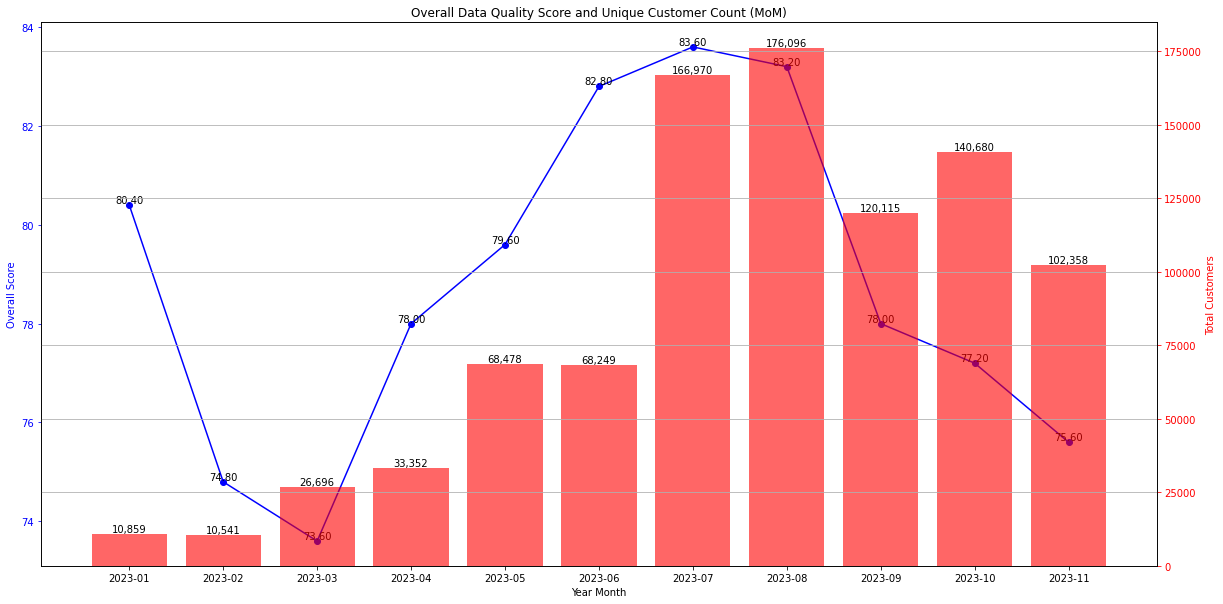

In [19]:
# Plot overall data quality score on a MoM basis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the overall score on the primary y-axis
ax1.plot(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
ax1.set_xlabel('Year Month')
ax1.set_ylabel('Overall Score', color='b')
ax1.tick_params('y', colors='b')

# Text annotations
for i, txt in enumerate(mom_overall_score_fil['Overall Score'].round(2)):
    ax1.text(mom_overall_score_fil['Year Month'].astype(str).iloc[i], txt, f'{txt:.2f}', ha='center', va='bottom')

# Secondary y-axis for the count of unique meter numbers
ax2 = ax1.twinx()
bars = ax2.bar(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Unique Meter Count'], alpha=0.6, color='red', label='Unique Meter Count')
ax2.set_ylabel('Total Customers', color='r')
ax2.tick_params('y', colors='r')

# Add labels on the bar chart with MoM figures
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# Show the plot
plt.title('Overall Data Quality Score and Unique Customer Count (MoM)')
plt.grid(True)
plt.show()


In [9]:
mom_overall_score_fil[['Year Month', 'Overall Score']].to_csv('mom_overall_score_.csv', index=False)

## QUALITY SCORE BY DATA COLLECTOR

In [21]:
df_x = df[df['year_month'] >= 202311]

field_metrics = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

collector_scores = calculate_quality_score_by_collector(df_x, field_metrics)

collector_scores


c:\Users\Moshood\OneDrive\dev\analysis\data_quality_management\metrics\dataquality.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  metrics['Completeness'] = df[field_name].count() / len(df) * 100
c:\Users\Moshood\OneDrive\dev\analysis\data_quality_management\metrics\dataquality.py:58: RuntimeWarning: invalid value encountered in longlong_scalars
  metrics['Completeness'] = df[field_name].count() / len(df) * 100
c:\Users\Moshood\OneDrive\dev\analysis\data_quality_management\metrics\dataquality.py:110: RuntimeWarning: invalid value encountered in longlong_scalars
  metrics['Completeness'] = df[field_name].count() / len(df) * 100


,Average Completeness,Average Validity,Average Integrity,Overall Average
ErnestKabu,34.47%,34.47%,38.36%,35.77%
AseiduMercy,33.33%,33.33%,40.00%,35.56%
AnthonyKwame,33.33%,33.33%,40.00%,35.56%
AbankwaLord,33.73%,33.73%,34.53%,34.00%
MensahS,32.87%,32.87%,35.68%,33.81%
...,...,...,...,...
SylviaMawunyo,20.00%,20.00%,26.67%,22.22%
CharlesOsei,20.00%,20.00%,26.67%,22.22%
AnnaAsantewaa,20.00%,20.00%,26.67%,22.22%
Akua,13.33%,13.33%,13.33%,13.33%


In [22]:
collector_scores.to_csv('collectors_score_november.csv', index=True)